# Cost Forecasting

Accurate cost forecasting is essential for businesses to make informed strategic decisions, optimize budgets, and ensure financial stability. Predicting future expenses helps companies avoid overspending, allocate resources efficiently, and enhance profitability in today’s dynamic market environment.

### PySpark Big Data extraction

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, from_json
from pyspark.sql.types import StructType, StructField, StringType, DoubleType

# Create Spark session
spark = SparkSession.builder \
    .config("spark.driver.host", "localhost") \
    .appName("Liquor_Sales") \
    .config("spark.driver.memory", "4g") \
    .config("spark.executor.memory", "4g") \
    .config("spark.executor.cores", "2") \
    .master("local[*]") \
    .getOrCreate()

# Path to the CSV file
csv_file_path = "Liquor_Sales.csv" 

# Read the CSV file
Liquor_Sales = spark.read.csv(csv_file_path, header=True, inferSchema=True)

In [2]:
from pyspark.sql.functions import unix_timestamp, from_unixtime, year, month, dayofmonth, dayofweek

Liquor_Sales = Liquor_Sales.withColumn("Date", from_unixtime(unix_timestamp('Date', 'MM/dd/yyy')))
Liquor_Sales = Liquor_Sales.withColumn("Year", year("Date").alias('year'))
Liquor_Sales = Liquor_Sales.withColumn("Month", month("Date").alias('month'))
Liquor_Sales = Liquor_Sales.withColumn("Day_of_month", dayofmonth("Date").alias('day'))
Liquor_Sales = Liquor_Sales.withColumn("Day_of_week", dayofweek("Date").alias('day'))

In [3]:
# Removing rows with any missing values.

Liquor_Sales = Liquor_Sales.na.drop(how="any")

### Business Metrics Creation

In [4]:
from pyspark.sql.functions import col,concat,lit
import pyspark.sql.functions as func

# Cost and Profit Metrics
Liquor_Sales = Liquor_Sales.withColumn("Category Name - Number", concat(col("Category Name"),lit(" - "),col("Category")))
Liquor_Sales = Liquor_Sales.withColumn("State Bottle Profit", col("State Bottle Retail") - col("State Bottle Cost"))
Liquor_Sales = Liquor_Sales.withColumn("Cost (Dollars)", func.round(col("State Bottle Cost") * col("Bottles Sold"),2))
Liquor_Sales = Liquor_Sales.withColumn("Profit (Dollars)", col("State Bottle Profit") * col("Bottles Sold"))

In [5]:
from pyspark.sql import functions as F

Item selection

In [6]:
Item_Description = "Blue Ox Gin"

In [7]:
Cost_df = Liquor_Sales.filter((col("Item Description")==Item_Description))\
.groupby("Date","Year","Month","Day_of_week","Day_of_month")\
.agg(
    F.sum("Bottles Sold").alias("Sales per Day"),
    F.median("State Bottle Retail").alias("Avg Price"),
    F.median("State Bottle Cost").alias("Avg Cost")
)\
.sort("Date")

In [8]:
Cost_df = Cost_df.toPandas().dropna()
Cost_df

,Date,Year,Month,Day_of_week,Day_of_month,Sales per Day,Avg Price,Avg Cost
0,2018-05-02 00:00:00,2018,5,4,2,6,9.750,6.50
1,2018-05-03 00:00:00,2018,5,5,3,2,5.250,3.50
2,2018-05-07 00:00:00,2018,5,2,7,24,4.875,3.25
3,2018-05-08 00:00:00,2018,5,3,8,3,4.500,3.00
4,2018-05-10 00:00:00,2018,5,5,10,3,5.250,3.50
...,...,...,...,...,...,...,...,...
447,2020-09-22 00:00:00,2020,9,3,22,12,5.250,3.50
448,2020-09-23 00:00:00,2020,9,4,23,12,6.000,4.00
449,2020-09-24 00:00:00,2020,9,5,24,48,6.000,4.00
450,2020-09-25 00:00:00,2020,9,6,25,12,5.250,3.50


Null Analysis

In [9]:
import pandas as pd

Cost_df_null_share = Cost_df.copy()

Cost_df_null_share['Date'] = pd.to_datetime(Cost_df_null_share['Date'])
Cost_df_null_share = Cost_df_null_share.set_index('Date').resample('D').median()

Cost_df_null_share

,Year,Month,Day_of_week,Day_of_month,Sales per Day,Avg Price,Avg Cost
Date,,,,,,,
2018-05-02,2018.0,5.0,4.0,2.0,6.0,9.75,6.5
2018-05-03,2018.0,5.0,5.0,3.0,2.0,5.25,3.5
2018-05-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-05-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-05-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
2020-09-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-09-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-09-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
# Null Analysis
import pandas as pd

Cost_df_null_dates  = Cost_df.copy()
Cost_df_null_dates['Date'] = pd.to_datetime(Cost_df_null_dates['Date'])
Cost_df_null_dates = Cost_df_null_dates.set_index('Date').resample('D').median()
#Cost_df_null_dates = Cost_df_null_dates[Cost_df_null_dates['Avg Cost'].isna()]

Cost_df_null_dates['Day_of_month'] = list(pd.Series(Cost_df_null_dates.index).dt.day)
Cost_df_null_dates['Year'] = list(pd.Series(Cost_df_null_dates.index).dt.year)
Cost_df_null_dates['Month'] = list(pd.Series(Cost_df_null_dates.index).dt.month)
Cost_df_null_dates['Day_of_week'] = list(pd.Series(Cost_df_null_dates.index).dt.day_name())
Cost_df_null_dates['Cost_is_null'] = Cost_df_null_dates['Avg Cost'].isna()
Cost_df_null_dates

,Year,Month,Day_of_week,Day_of_month,Sales per Day,Avg Price,Avg Cost,Cost_is_null
Date,,,,,,,,
2018-05-02,2018,5,Wednesday,2,6.0,9.75,6.5,False
2018-05-03,2018,5,Thursday,3,2.0,5.25,3.5,False
2018-05-04,2018,5,Friday,4,NaN,NaN,NaN,True
2018-05-05,2018,5,Saturday,5,NaN,NaN,NaN,True
2018-05-06,2018,5,Sunday,6,NaN,NaN,NaN,True
...,...,...,...,...,...,...,...,...
2020-09-26,2020,9,Saturday,26,NaN,NaN,NaN,True
2020-09-27,2020,9,Sunday,27,NaN,NaN,NaN,True
2020-09-28,2020,9,Monday,28,NaN,NaN,NaN,True


In [11]:
import numpy as np
Null_days_of_week = pd.DataFrame(np.round(Cost_df_null_dates.groupby('Day_of_week')['Cost_is_null'].value_counts(normalize=True)*100,0).astype(int).rename('%').sort_values(ascending=False)).reset_index()
Null_days_of_week[Null_days_of_week.Cost_is_null==True]

,Day_of_week,Cost_is_null,%
0,Sunday,True,100
1,Saturday,True,98
7,Friday,True,42
8,Wednesday,True,30
9,Monday,True,29
10,Tuesday,True,28
11,Thursday,True,15


In [12]:
Null_days_of_month = pd.DataFrame(np.round(Cost_df_null_dates.groupby('Day_of_month')['Cost_is_null'].value_counts(normalize=True)*100,0).astype(int).rename('%').sort_values(ascending=False)).reset_index()
Null_days_of_month[Null_days_of_month.Cost_is_null==True]

,Day_of_month,Cost_is_null,%
0,8,True,66
2,24,True,62
7,29,True,57
9,9,True,55
10,16,True,55
16,19,True,52
23,5,True,52
24,2,True,52
26,3,True,52
27,30,True,52


In [13]:
Null_month = pd.DataFrame(np.round(Cost_df_null_dates.groupby('Month')['Cost_is_null'].value_counts(normalize=True)*100,0).astype(int).rename('%').sort_values(ascending=False)).reset_index()
Null_month[Null_month.Cost_is_null==True]

,Month,Cost_is_null,%
1,11,True,57
5,5,True,53
8,6,True,52
9,12,True,52
12,3,True,50
15,9,True,48
17,7,True,47
18,2,True,47
19,10,True,47
20,8,True,45


In [14]:
Null_year = pd.DataFrame(np.round(Cost_df_null_dates.groupby('Year')['Cost_is_null'].value_counts(normalize=True)*100,0).astype(int).rename('%').sort_values(ascending=False)).reset_index()
Null_year[Null_year.Cost_is_null==True]

,Year,Cost_is_null,%
0,2018,True,62
3,2019,True,44
4,2020,True,43


## Time-Series Analysis

In [15]:
Cost_df

,Date,Year,Month,Day_of_week,Day_of_month,Sales per Day,Avg Price,Avg Cost
0,2018-05-02 00:00:00,2018,5,4,2,6,9.750,6.50
1,2018-05-03 00:00:00,2018,5,5,3,2,5.250,3.50
2,2018-05-07 00:00:00,2018,5,2,7,24,4.875,3.25
3,2018-05-08 00:00:00,2018,5,3,8,3,4.500,3.00
4,2018-05-10 00:00:00,2018,5,5,10,3,5.250,3.50
...,...,...,...,...,...,...,...,...
447,2020-09-22 00:00:00,2020,9,3,22,12,5.250,3.50
448,2020-09-23 00:00:00,2020,9,4,23,12,6.000,4.00
449,2020-09-24 00:00:00,2020,9,5,24,48,6.000,4.00
450,2020-09-25 00:00:00,2020,9,6,25,12,5.250,3.50


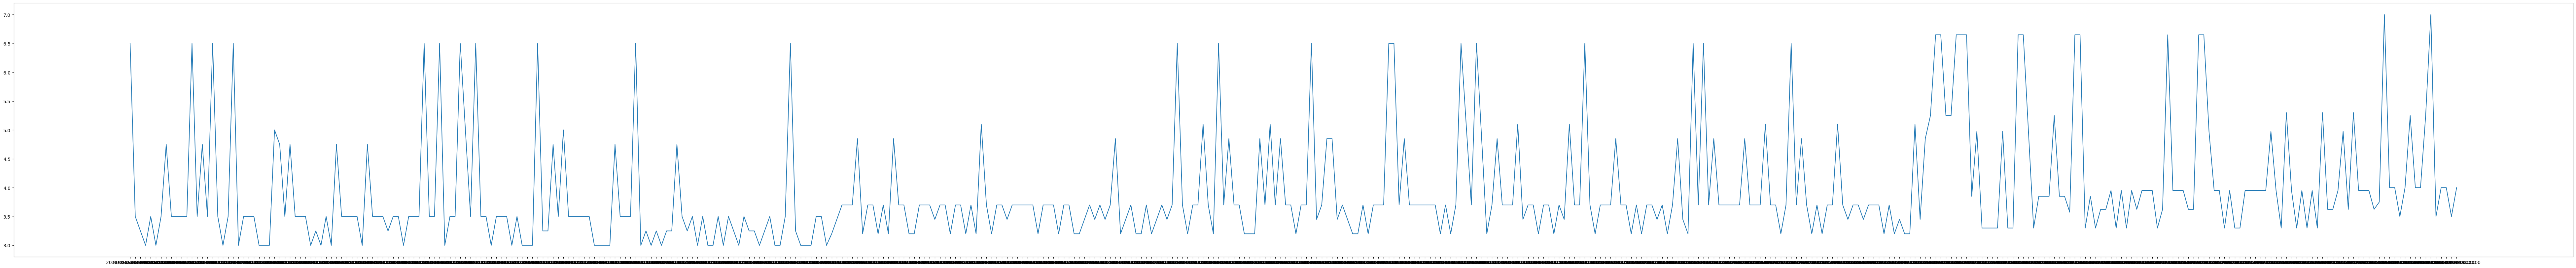

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(100, 10))
plt.plot(Cost_df.set_index('Date')['Avg Cost'])
plt.show()

ADF test 

The Augmented Dickey-Fuller (ADF) test is a statistical test used to determine if a time series is stationary or not. A stationary time series has properties like mean, variance, and autocorrelation that are constant over time. The ADF test is mainly used to check for the presence of a unit root in the time series data. A unit root indicates that the time series is non-stationary, meaning it has a time-dependent structure that could lead to misleading statistical inferences.

In [17]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller

# Create or load your time series data
# For example, let's say you have a pandas Series named 'ts'

# Assuming ts is your time series data
result = adfuller(Cost_df.set_index('Date')['Avg Cost'])

# Extract and print the test results
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

ADF Statistic: -9.684134376403623
p-value: 1.1829520477396396e-16
Critical Values:
	1%: -3.4449982835447894
	5%: -2.8679986379826814
	10%: -2.5702102140862397


The test strongly suggests that the series is stationary time-series, meaning it does not have a unit root. This is an important finding when working with time series data, as many time series models (like ARIMA) assume that the data is stationary.

In [23]:
Cost_df['Date'] = pd.to_datetime(Cost_df['Date'] )
Cost_time_Series = Cost_df.set_index('Date')['Avg Cost']
#Cost_time_Series = Cost_time_Series.resample('D').median().interpolate('quadratic')
Cost_time_Series

Date
2018-05-02    6.50
2018-05-03    3.50
2018-05-07    3.25
2018-05-08    3.00
2018-05-10    3.50
              ... 
2020-09-22    3.50
2020-09-23    4.00
2020-09-24    4.00
2020-09-25    3.50
2020-09-30    4.00
Name: Avg Cost, Length: 452, dtype: float64

#### Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) 

The ACF measures the correlation between the time series and lagged versions of itself. It shows the correlation of the series with its own past values at various lags. In simpler terms, it helps you see how strongly the current observation in the time series is related to past observations.

The PACF measures the correlation between the time series and its lagged values, controlling for the values of the time series at all shorter lags. Essentially, it gives the amount of correlation between a time series and its lag that is not explained by correlations at all lower lags.

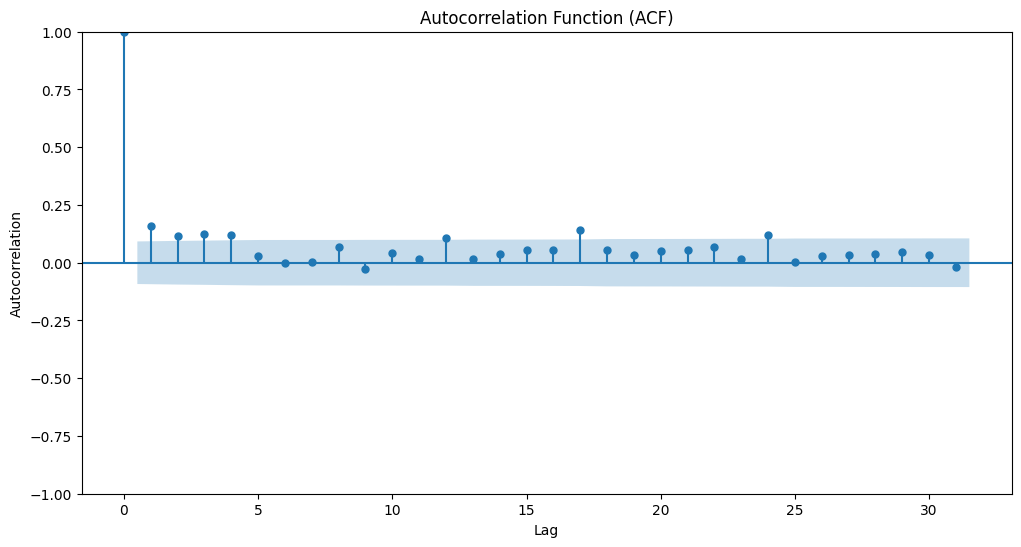

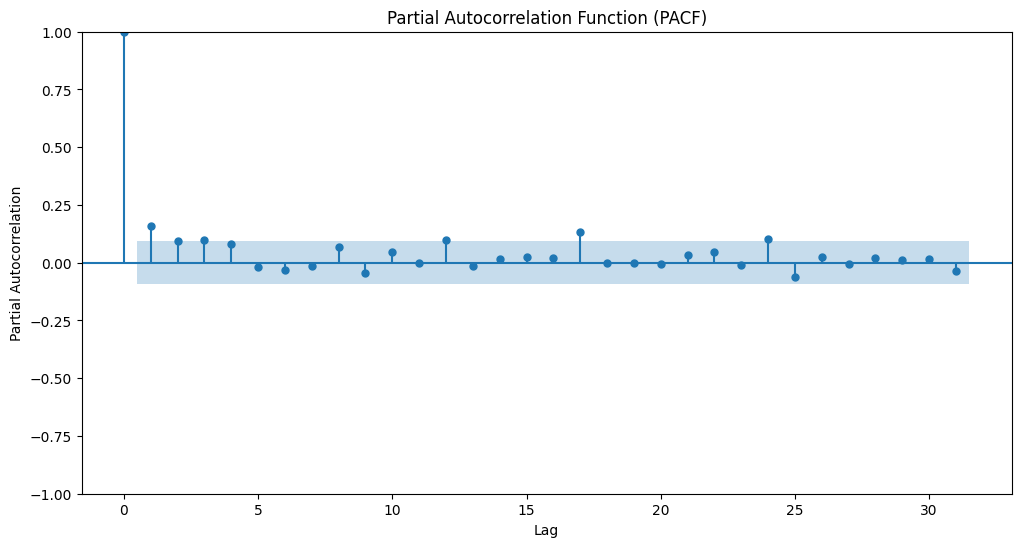

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Assuming you have a time series data stored in a pandas DataFrame called 'ts_data'
# Replace this with your actual time series data

# Plot ACF
plt.figure(figsize=(12, 6))
plot_acf(Cost_time_Series, lags=31, ax=plt.gca())  # Change 'lags' to set the number of lags to display
plt.title('Autocorrelation Function (ACF)')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

# Plot PACF
plt.figure(figsize=(12, 6))
plot_pacf(Cost_time_Series, lags=31, ax=plt.gca())  # Change 'lags' to set the number of lags to display
plt.title('Partial Autocorrelation Function (PACF)')
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.show()

Auto Regressive Order (based on PACF) = 4

Moving Average Order (based on ACF) = 4

# Forecasting

## ARIMA

C:\Users\abhij\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\abhij\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\abhij\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-st

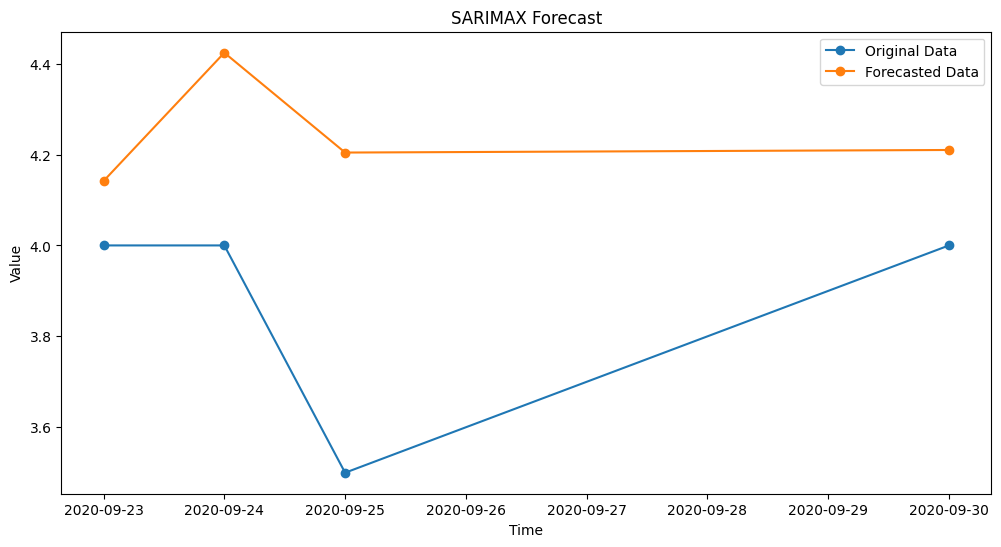

                               SARIMAX Results                                
Dep. Variable:               Avg Cost   No. Observations:                  448
Model:               SARIMAX(4, 0, 4)   Log Likelihood                -603.423
Date:                Fri, 16 Aug 2024   AIC                           1224.845
Time:                        10:37:59   BIC                           1261.788
Sample:                             0   HQIC                          1239.408
                                - 448                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5971      0.032    -18.594      0.000      -0.660      -0.534
ar.L2          0.0468      0.030      1.575      0.115      -0.011       0.105
ar.L3          0.6023      0.030     19.962      0.0

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Assuming you have a time series data stored in a pandas DataFrame called 'ts_data'
# Replace this with your actual time series data

# Forecast future values
forecast_steps = 4  # Number of steps to forecast into the future

# Fit SARIMAX model

model = SARIMAX(Cost_time_Series.iloc[:-forecast_steps], order=(4, 0, 4), exog=None)
results = model.fit()

forecast = results.forecast(steps=forecast_steps)
forecast = pd.Series(list(forecast),index=pd.DatetimeIndex(list(Cost_time_Series.iloc[-forecast_steps:].index)))

# Plot the original time series and forecasted values
original = pd.Series(Cost_time_Series.iloc[-forecast_steps:])
plt.figure(figsize=(12, 6))
plt.plot(original, label='Original Data',marker ='o')
plt.plot(forecast, label='Forecasted Data',marker ='o')
plt.title('SARIMAX Forecast')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

# Print summary of the model
print(results.summary())

In [26]:
#MAE

np.mean(np.abs(forecast - original))

0.369962249671675

In [27]:
# MAPE

np.mean(np.abs(forecast - original)/original)*100

9.877902069579852

In [28]:
# RMSE

np.sqrt(np.mean(np.power((forecast - original),2)))

0.43008820699387235

In [29]:
# RMSPE

np.sqrt(np.mean(np.square((forecast - original)/original)))*100

11.80409846746389

## Auto ARIMA

In [30]:
import pandas as pd
from pmdarima import auto_arima

forecast_steps = 4

# Fit Auto SARIMA model
auto_model = auto_arima(Cost_time_Series.iloc[:-forecast_steps],max_p=7,max_q=8,max_P=7,max_Q=8)  # 'm' represents the seasonality, set to 28 based on your observation
# 'seasonal=True' enables seasonal modeling
# 'm=28' specifies the seasonal period, adjust this based on your data's seasonality

# Print model summary
print(auto_model.summary())

# Get the best SARIMA parameters
print("Best SARIMA parameters:", auto_model.order, auto_model.seasonal_order)

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  448
Model:               SARIMAX(1, 1, 2)   Log Likelihood                -600.862
Date:                Fri, 16 Aug 2024   AIC                           1209.725
Time:                        10:38:04   BIC                           1226.135
Sample:                             0   HQIC                          1216.195
                                - 448                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6299      0.221      2.853      0.004       0.197       1.063
ma.L1         -1.5016      0.243     -6.173      0.000      -1.978      -1.025
ma.L2          0.5109      0.237      2.153      0.0

C:\Users\abhij\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\abhij\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


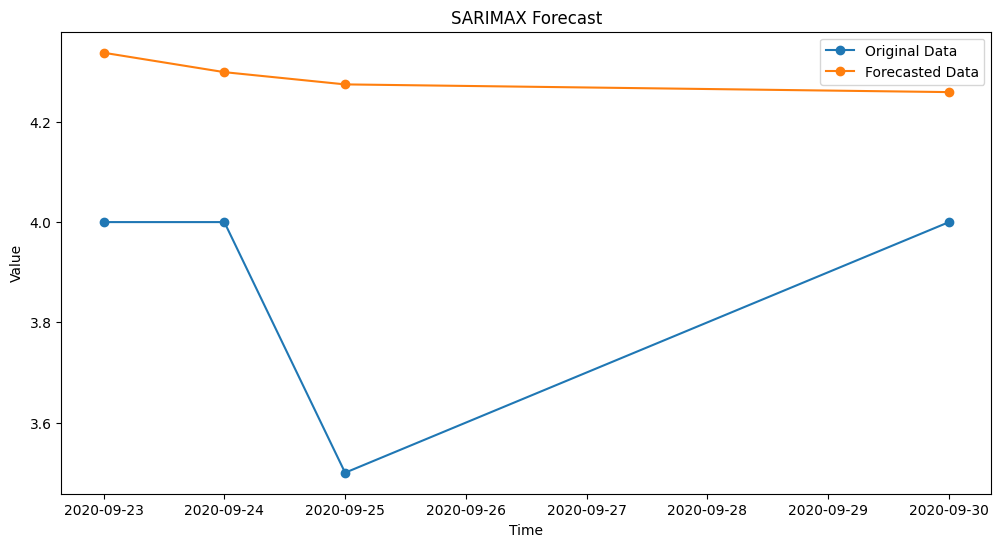

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  448
Model:               SARIMAX(1, 1, 2)   Log Likelihood                -600.862
Date:                Fri, 16 Aug 2024   AIC                           1209.725
Time:                        10:38:05   BIC                           1226.135
Sample:                             0   HQIC                          1216.195
                                - 448                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6299      0.221      2.853      0.004       0.197       1.063
ma.L1         -1.5016      0.243     -6.173      0.000      -1.978      -1.025
ma.L2          0.5109      0.237      2.153      0.0

In [31]:
forecast = auto_model.predict(steps=forecast_steps)[:forecast_steps]
forecast = pd.Series(list(forecast),index=pd.DatetimeIndex(list(Cost_time_Series.iloc[-forecast_steps:].index)))

# Plot the original time series and forecasted values
original = pd.Series(Cost_time_Series.iloc[-forecast_steps:])

# Plot the original time series and forecasted values
plt.figure(figsize=(12, 6))
plt.plot(original, label='Original Data',marker='o')
plt.plot(forecast, label='Forecasted Data',marker='o')
plt.title('SARIMAX Forecast')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

# Print summary of the model
print(auto_model.summary())

In [32]:
#MAE

np.mean(np.abs(forecast - original))

0.41775865046829797

In [33]:
# MAPE

np.mean(np.abs(forecast - original)/original)*100

11.135664431562509

In [34]:
# RMSE

np.sqrt(np.mean(np.power((forecast - original),2)))

0.46665135182149664

In [35]:
# RMSPE

np.sqrt(np.mean(np.square((forecast - original)/original)))*100

12.837794167569024

## LSTM Time-Series

LSTM, a type of recurrent neural network (RNN), is particularly well-suited for time-series forecasting due to its ability to capture long-term dependencies in sequential data.

In [110]:
import torch
# Set the random seed for reproducibility
random_seed = 42
torch.manual_seed(random_seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(random_seed)

In [111]:
Cost_time_Series

Date
2018-05-02    6.50
2018-05-03    3.50
2018-05-07    3.25
2018-05-08    3.00
2018-05-10    3.50
              ... 
2020-09-22    3.50
2020-09-23    4.00
2020-09-24    4.00
2020-09-25    3.50
2020-09-30    4.00
Name: Avg Cost, Length: 452, dtype: float64

In [112]:
lookback = 5
lookahead = 5

In [113]:
inference_dates = Cost_time_Series.iloc[-(lookback+lookahead):]
inference_dates

Date
2020-09-15    5.25
2020-09-16    4.00
2020-09-17    4.00
2020-09-18    5.25
2020-09-21    7.00
2020-09-22    3.50
2020-09-23    4.00
2020-09-24    4.00
2020-09-25    3.50
2020-09-30    4.00
Name: Avg Cost, dtype: float64

In [114]:
train_valid_dates = Cost_time_Series[:-lookahead]
train_valid_dates

Date
2018-05-02    6.50
2018-05-03    3.50
2018-05-07    3.25
2018-05-08    3.00
2018-05-10    3.50
              ... 
2020-09-15    5.25
2020-09-16    4.00
2020-09-17    4.00
2020-09-18    5.25
2020-09-21    7.00
Name: Avg Cost, Length: 447, dtype: float64

In [115]:
train_size = int(0.8*len(train_valid_dates))
train_dates  = train_valid_dates[:train_size]
train_dates

Date
2018-05-02    6.50
2018-05-03    3.50
2018-05-07    3.25
2018-05-08    3.00
2018-05-10    3.50
              ... 
2020-04-07    5.25
2020-04-09    5.25
2020-04-10    6.65
2020-04-13    6.65
2020-04-14    6.65
Name: Avg Cost, Length: 357, dtype: float64

In [116]:
valid_dates  = train_valid_dates[train_size:]
valid_dates

Date
2020-04-15    3.850
2020-04-20    4.975
2020-04-21    3.300
2020-04-22    3.300
2020-04-23    3.300
              ...  
2020-09-15    5.250
2020-09-16    4.000
2020-09-17    4.000
2020-09-18    5.250
2020-09-21    7.000
Name: Avg Cost, Length: 90, dtype: float64

In [117]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import numpy as np

# Example with StandardScaler
scaler = MinMaxScaler().fit(pd.DataFrame(train_dates))
normalized_train_data = scaler.transform(pd.DataFrame(train_dates))
normalized_valid_data = scaler.transform(pd.DataFrame(valid_dates))
normalized_inference_data = scaler.transform(pd.DataFrame(inference_dates))

In [118]:
normalized_train_data.shape

(357, 1)

In [119]:
normalized_valid_data.shape

(90, 1)

In [120]:
normalized_inference_data.shape

(10, 1)

In [121]:
import torch
import torch.nn as nn

def create_sequences(data, n_input, n_output):
    sequences = []
    for i in range(len(data) - n_input - n_output + 1):
        input_seq = data[i:i+n_input]
        output_seq = data[i+n_input:i+n_input+n_output]
        sequences.append((input_seq, output_seq))
    return sequences

train_sequences = create_sequences(normalized_train_data, lookback, lookahead)
valid_sequences = create_sequences(normalized_valid_data, lookback, lookahead)
inference_sequences = create_sequences(normalized_inference_data, lookback, lookahead)

# Convert sequences to PyTorch tensors
X_train_sequences = torch.tensor([s[0] for s in train_sequences], dtype=torch.float32)
y_train_sequences = torch.tensor([s[1] for s in train_sequences], dtype=torch.float32).squeeze()

# Convert sequences to PyTorch tensors
X_valid_sequences = torch.tensor([s[0] for s in valid_sequences], dtype=torch.float32)
y_valid_sequences = torch.tensor([s[1] for s in valid_sequences], dtype=torch.float32).squeeze()

# Convert sequences to PyTorch tensors
X_inference_sequences = torch.tensor([s[0] for s in inference_sequences], dtype=torch.float32)
y_inference_sequences = torch.tensor([s[1] for s in inference_sequences], dtype=torch.float32).squeeze()

In [122]:
X_train_sequences.shape , y_train_sequences.shape

(torch.Size([348, 5, 1]), torch.Size([348, 5]))

In [123]:
X_valid_sequences.shape , y_valid_sequences.shape

(torch.Size([81, 5, 1]), torch.Size([81, 5]))

In [124]:
X_inference_sequences.shape , y_inference_sequences.shape

(torch.Size([1, 5, 1]), torch.Size([5]))

In [125]:
# import torch

# print(f"Is CUDA supported by this system? {torch.cuda.is_available()}")
# print(f"CUDA version: {torch.version.cuda}")
 
# # Storing ID of current CUDA device
# cuda_id = torch.cuda.current_device()
# print(f"ID of current CUDA device: {torch.cuda.current_device()}")
       

# print(f"Name of current CUDA device: {torch.cuda.get_device_name(cuda_id)}")

In [126]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

input_size = 1  # Number of features (e.g., univariate time series)
hidden_size = 8
num_layers = 1

model = LSTMModel(input_size, hidden_size, num_layers, lookahead)

In [127]:
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

num_epochs = 100000
batch_size = 1000

best_train_loss = float('inf')
best_val_loss = float('inf')
epochs_no_improve = 0
patience = 1000  # Early stopping patience
best_model = LSTMModel(input_size, hidden_size, num_layers, lookahead)

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    for i in range(0, len(X_train_sequences), batch_size):
        x_batch = X_train_sequences[i:i+batch_size]
        y_batch = y_train_sequences[i:i+batch_size]

        outputs = model(x_batch)

        optimizer.zero_grad()
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
    
    # Calculate validation loss
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        val_outputs = model(X_valid_sequences)
        val_loss = criterion(val_outputs, y_valid_sequences)

    if val_loss < best_val_loss:
        best_train_loss = loss
        best_val_loss = val_loss
        epochs_no_improve = 0
        best_model = model
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= patience:
        print(f'Early stopping at {epoch+1}')
        print(f'Best Epoch [{epoch+1-patience}/{num_epochs}], Loss: {best_train_loss.item():.4f}, Val Loss: {best_val_loss.item():.4f}')
        break
    
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}')


Epoch [10/100000], Loss: 0.1582, Val Loss: 0.2085
Epoch [20/100000], Loss: 0.1482, Val Loss: 0.1925
Epoch [30/100000], Loss: 0.1478, Val Loss: 0.2002
Epoch [40/100000], Loss: 0.1474, Val Loss: 0.1904
Epoch [50/100000], Loss: 0.1472, Val Loss: 0.1900


Epoch [60/100000], Loss: 0.1470, Val Loss: 0.1889
Epoch [70/100000], Loss: 0.1469, Val Loss: 0.1891
Epoch [80/100000], Loss: 0.1468, Val Loss: 0.1892
Epoch [90/100000], Loss: 0.1467, Val Loss: 0.1876
Epoch [100/100000], Loss: 0.1466, Val Loss: 0.1885
Epoch [110/100000], Loss: 0.1465, Val Loss: 0.1890
Epoch [120/100000], Loss: 0.1463, Val Loss: 0.1894
Epoch [130/100000], Loss: 0.1462, Val Loss: 0.1896
Epoch [140/100000], Loss: 0.1460, Val Loss: 0.1902
Epoch [150/100000], Loss: 0.1459, Val Loss: 0.1910
Epoch [160/100000], Loss: 0.1457, Val Loss: 0.1908
Epoch [170/100000], Loss: 0.1456, Val Loss: 0.1908
Epoch [180/100000], Loss: 0.1454, Val Loss: 0.1907
Epoch [190/100000], Loss: 0.1453, Val Loss: 0.1910
Epoch [200/100000], Loss: 0.1452, Val Loss: 0.1914
Epoch [210/100000], Loss: 0.1452, Val Loss: 0.1916
Epoch [220/100000], Loss: 0.1451, Val Loss: 0.1914
Epoch [230/100000], Loss: 0.1451, Val Loss: 0.1912
Epoch [240/100000], Loss: 0.1450, Val Loss: 0.1911
Epoch [250/100000], Loss: 0.1449, V

In [128]:
X_inference_sequences.shape , y_inference_sequences.shape

(torch.Size([1, 5, 1]), torch.Size([5]))

In [129]:
y_inference = y_inference_sequences.detach().numpy()
y_inference

array([0.1369863, 0.2739726, 0.2739726, 0.1369863, 0.2739726],
      dtype=float32)

In [130]:
y_inference = scaler.inverse_transform(pd.DataFrame(y_inference)).flatten()
y_inference

array([3.5, 4. , 4. , 3.5, 4. ], dtype=float32)

In [131]:
y_pred = best_model(X_inference_sequences).detach().numpy()
y_pred = scaler.inverse_transform(y_pred).flatten()
y_pred

array([3.8027377, 4.4857187, 4.289496 , 3.8153014, 3.9072173],
      dtype=float32)

In [132]:
np.mean(np.abs(y_pred- y_inference))

0.2972073

In [133]:
np.mean(np.abs(y_pred- y_inference)/y_inference)*100

7.871638238430023

In [134]:
# RMSE

np.sqrt(np.mean(np.power((y_pred - y_inference),2)))

0.32230556

In [135]:
# RMSPE

np.sqrt(np.mean(np.square((y_pred - y_inference)/y_inference)))*100

8.49921777844429

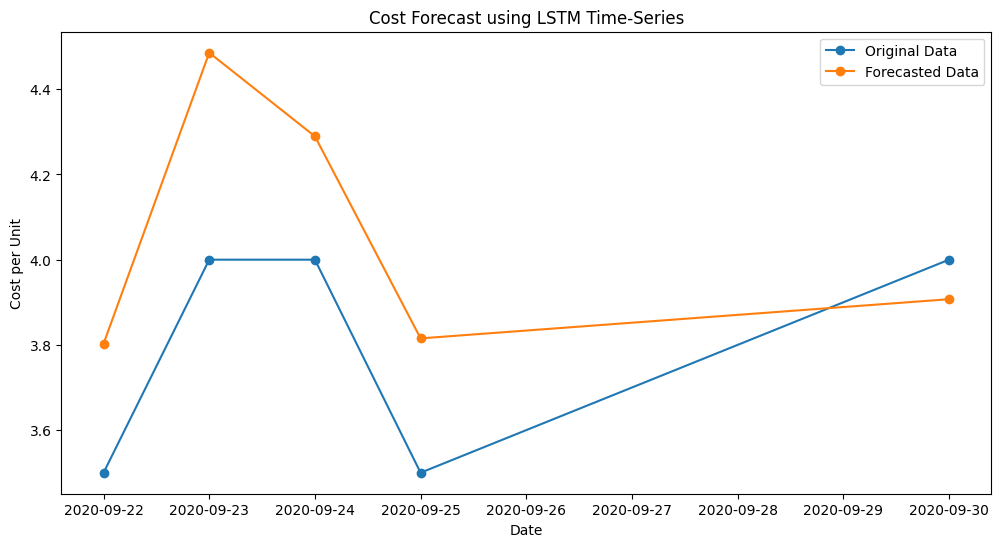

In [137]:
# Plot the original time series and forecasted values
plt.figure(figsize=(12, 6))
plt.plot(pd.Series(y_inference,index=pd.DatetimeIndex(list(Cost_time_Series.iloc[-lookahead:].index))), label='Original Data',marker='o')
plt.plot(pd.Series(y_pred,index=pd.DatetimeIndex(list(Cost_time_Series.iloc[-lookahead:].index))), label='Forecasted Data',marker='o')
plt.title('Cost Forecast using LSTM Time-Series')
plt.xlabel('Date')
plt.ylabel('Cost per Unit')
plt.legend()
plt.show()


# Thus, LSTM provides less MAPE and RMSPE compared to ARIMA, and its forecasted plot also aligns best with original data plot